Preferred python version = 3.10

In [1]:
!python --version

Python 3.10.12


# ***Packages***

In [2]:
%pip install matplotlib
%pip install scanpy
%pip install tqdm

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
from tqdm import tqdm

Make sure you add the modified packages in sys.path

In [4]:
import locale
import inspect
import os
import sys
locale.getpreferredencoding = lambda: "UTF-8"

sys.path.append('/content/drive/MyDrive/MODIFIED_PYTHON_MODULES/modified_ot')
import ot

module_path = inspect.getfile(ot)
# Get the directory containing the module
module_directory = os.path.dirname(module_path)

print(f"Module directory: {module_directory}")

sys.path.append('/content/drive/MyDrive/MODIFIED_PYTHON_MODULES/modified_paste')
import paste as pst

module_path = inspect.getfile(pst)
module_directory = os.path.dirname(module_path)
print(f"Module directory: {module_directory}")

Module directory: /content/drive/MyDrive/MODIFIED_PYTHON_MODULES/modified_ot/ot
Module directory: /content/drive/MyDrive/MODIFIED_PYTHON_MODULES/modified_paste/paste


Check for GPU support

In [5]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# ***Data***

In [6]:
data_dir = "/content/drive/MyDrive/Thesis_data_anup/Mouse_brain_MERFISH/"

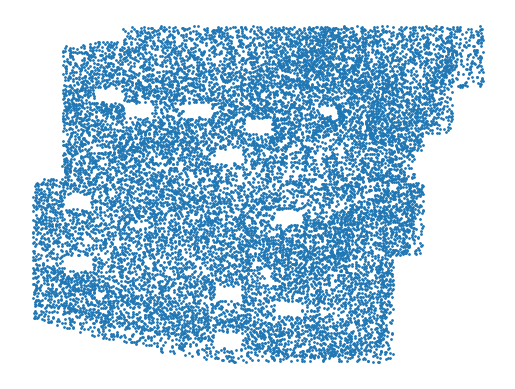

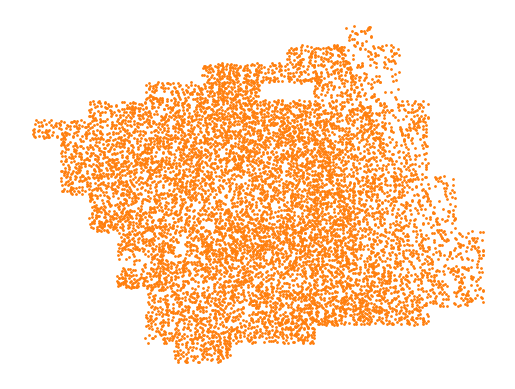

In [7]:
data1="adata90wk_donor_id_2_slice_0"
data2="adata90wk_donor_id_5_slice_1"

sliceA = sc.read_h5ad(data_dir + data1 + ".h5ad")
sliceB = sc.read_h5ad(data_dir + data2 + ".h5ad")


xI = np.array(sliceA.obsm['spatial'] [:, 0])
yI = np.array(sliceA.obsm['spatial'] [:, 1])

xJ = np.array(sliceB.obsm['spatial'] [:, 0])
yJ = np.array(sliceB.obsm['spatial'] [:, 1])

# plot
# fig,ax = plt.subplots()
plt.scatter(xI,yI,s=1,alpha=1, label='source')
# plt.legend(markerscale = 10)
plt.axis("off")
plt.show()

plt.scatter(xJ,yJ,s=1,alpha=1, c='#ff7f0e',  label='target')
# plt.legend(markerscale = 10)
plt.axis("off")
plt.show()




***Initially rotate the slices (Optional)***

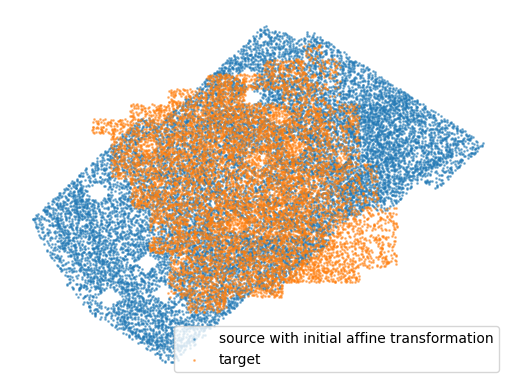

In [8]:
theta_deg = 40
theta0 = (np.pi/180)*-theta_deg

#rotation matrix
#rotates about the origin
L = np.array([[np.cos(theta0),-np.sin(theta0)],
              [np.sin(theta0),np.cos(theta0)]])

source_L = np.matmul(L , np.array([xI, yI]))
xI_L = source_L[0]
yI_L = source_L[1]

#translation matrix
#effectively makes the rotation about the centroid of I (i.e the means of xI and yI])
#and also moves the centroid of I to the centroid of J
T = np.array([ np.mean(xI)- np.cos(theta0)*np.mean(xI) +np.sin(theta0)*np.mean(yI) - (np.mean(xI)-np.mean(xJ)),
              np.mean(yI)- np.sin(theta0)*np.mean(xI) -np.cos(theta0)*np.mean(yI) - (np.mean(yI)-np.mean(yJ))])

xI_L_T = xI_L + T[0]
yI_L_T = yI_L + T[1]


plt.scatter(xI_L_T,yI_L_T,s=1,alpha=0.5, label='source with initial affine transformation')
plt.scatter(xJ,yJ,s=1,alpha=0.5, label = 'target')
plt.axis("off")
plt.legend()
plt.show()

***Use the coordinates after the affine transformation (optional)***

In [9]:
transformed_sliceA = sliceA
transformed_sliceA.obsm['spatial'] = np.array([xI_L_T, yI_L_T]).T

# ***Apply PROMT***

In [10]:

%%time

pi12, neighbor_initial_obj, initial_obj_gene_cos, neighbor_final_obj, obj_gene_cos = pst.pairwise_align_MERFISH(sliceA = sliceA, sliceB = sliceB, backend = ot.backend.TorchBackend(),
                                       use_gpu = True, return_obj = True,
                                       sliceA_name=data1, sliceB_name=data2, alpha=0.1, beta= 0.8, gamma=0.8, radius=100,
                                       numItermax = 20000, overwrite = True, neighborhood_dissimilarity = 'jsd',
                                       filePath = '/content/drive/MyDrive/Thesis_data_anup/local_data')

gpu is not available, resorting to torch cpu.
beta:  0.8
CUDA is not available on your system.
Calculating cosine dist of gene expression for slice A and slice B
Saving precomputed cosine dist of gene expression for slice A and slice B
Calculating niche distribution of slice A
radius 100
radius print done


100%|██████████| 15694/15694 [00:06<00:00, 2295.71it/s]


Saving niche distribution of slice A
Calculating niche distribution of slice B
radius 100
radius print done


100%|██████████| 9644/9644 [00:03<00:00, 2600.00it/s]


Saving niche distribution of slice B
Calculating JSD of niche distribution for slice A and slice B
Calculating cost matrix


100%|██████████| 15694/15694 [01:58<00:00, 131.93it/s]


Finished calculating cost matrix
Saving precomputed JSD of niche distribution for slice A and slice B
Initial objective neighbor (jsd): 0.5240073202896296
Initial objective gene expr (cosine_dist): 0.9886476424580461
alpha: 0.1
beta: 0.8
gamma: 0.8
numItermax: 20000


/content/drive/MyDrive/MODIFIED_PYTHON_MODULES/modified_ot/ot/lp/__init__.py:343: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


Final objective neighbor (jsd): 0.4489789742272253

Final objective (cosine_dist): 0.6544734774742212

Runtime: 229.33886075019836 seconds

CPU times: user 14min 4s, sys: 3min 13s, total: 17min 17s
Wall time: 3min 49s


***Save the pi matrix (Optional)***

In [11]:
filePath = '/content/drive/MyDrive/Thesis_data_anup/local_data'

In [12]:
np.save(f"{filePath}/pi_matrix_{data1}_{data2}.npy", pi12)

# ***Visualize the alignment***

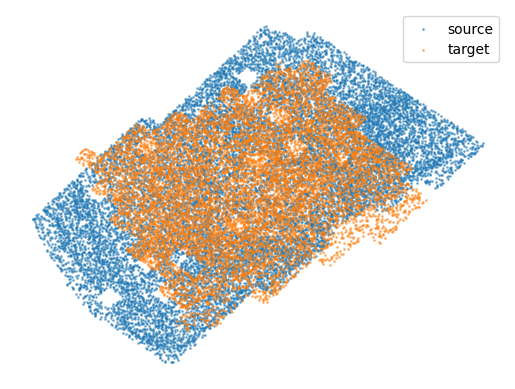

In [13]:
# To visualize the alignment you can stack the slices
# according to the alignment pi
slices, pis = [sliceA, sliceB], [pi12]
new_slices = pst.stack_slices_pairwise(slices, pis)

slice_colors = ['#e41a1c','#377eb8']

xI_new = new_slices[0].obsm['spatial'][:, 0]
yI_new = new_slices[0].obsm['spatial'][:, 1]

xJ_new = new_slices[1].obsm['spatial'][:, 0]
yJ_new = new_slices[1].obsm['spatial'][:, 1]


plt.scatter(xI_new,yI_new,s=1,alpha=0.5, label='source')
plt.scatter(xJ_new,yJ_new,s=1,alpha=0.5, label = 'target')
plt.axis("off")
plt.legend()

plt.show()

# ***Get the Performance Metrics***

In [14]:
def cell_type_matching_metric(sliceA, sliceB, pi_mat):

    matching_cell_types = 0

    max_indices = np.argmax(pi_mat, axis=1)
    for i, max_index in enumerate(max_indices):

        if sliceA.obs.iloc[i]['cell_type_annot'] == sliceB.obs.iloc[max_index]['cell_type_annot']:
            matching_cell_types += 1


    percentage = matching_cell_types / sliceA.n_obs * 100

    return matching_cell_types, percentage



In [15]:

neighborhood_improvement = (neighbor_initial_obj - neighbor_final_obj)/neighbor_initial_obj * 100
gene_expr_improvement = (initial_obj_gene_cos - obj_gene_cos)/initial_obj_gene_cos * 100
matching_cell_types, percentage = cell_type_matching_metric(new_slices[0], new_slices[1], pi12)

print(f"neighborhood_improvement: {neighborhood_improvement:.2f}%")
print(f"gene_expr_improvement: {gene_expr_improvement:.2f}%")
print(f"cell_type_matching_percentage: {percentage:.2f}%", )

neighborhood_improvement: 14.32%
gene_expr_improvement: 33.80%
cell_type_matching_percentage: 86.77%
